# Notebook to make Fig. 5

In [1]:
# Import necessary packages & set-up plotting aesthetics
import numpy as np 
import pylab
import pandas as pd
from scipy.stats import gaussian_kde
import json

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style

from fig_helper_functions import *

style.use('plotting.mplstyle')

import seaborn as sns
sns.set_palette('colorblind')

import sys
sys.path.append('./../Code/PopulationInference')
from posterior_helper_functions import mu_sigma2_to_a_b, calculate_betaDistribution, calculate_Double_Gaussian

### Data for true underlying populations

Load data

In [2]:
f_root = '../Data/InjectedPopulationParameters/' 
pop1 = pd.read_json(f_root+'underlying_population1_highSpinPrecessing_fullmassrange.json')
pop2 = pd.read_json(f_root+'underlying_population2_mediumSpin_fullmassrange.json')
pop3 = pd.read_json(f_root+'underlying_population3_lowSpinAligned_fullmassrange.json')

Make KDEs for spin parameters of underlying populations

In [3]:
# Set up grids to evaluate KDEs on
chi_grid = np.linspace(0,1,500)
cost_grid =  np.linspace(-1,1,500)
chieff_grid =  np.linspace(-1,1,500)
chip_grid =  np.linspace(0,1,500)

# Dict in which to store KDEs
kde_dict = {}

# Cycle through populations
for pop,pop_key in zip([pop1, pop2, pop3], ['pop 1', 'pop 2', 'pop 3']):
    
    # Use function in fig_helper_functions
    kde_dict[pop_key] = get_KDE_dict_spins(pop)

### Load `emcee` hierarchical inference results

Load data

In [4]:
# For loading files
model = 'betaPlusDoubleGaussian'
pops = ['1', '2', '3']
nevents = ['70', '300'] 
sigmas = ['0.1', '0.5']
date = '101923'

# Make Dict
data_dict = {}

# Cycle through the different populations and no. of events
for pop in pops: 
    data_pop = {}
    for nevent in nevents: 
        data_nevents = {}
        for sigma_meas in sigmas:
        
            print(pop, nevent, 'sigma_meas =', sigma_meas)

            name = f"../Data/PopulationInferenceOutput/{model}/{date}_{model}_pop{pop}_{nevent}events_gaussian_sigma_{sigma_meas}.json"

            with open(name, 'r') as f:
                data = json.load(f)
                
            data_nevents[f'gaussian_sigma_{sigma_meas}'] = data
            
        data_pop[nevent+' events'] = data_nevents    
            
    data_dict['pop '+pop] = data_pop

1 70 sigma_meas = 0.1
1 70 sigma_meas = 0.5
1 300 sigma_meas = 0.1
1 300 sigma_meas = 0.5
2 70 sigma_meas = 0.1
2 70 sigma_meas = 0.5
2 300 sigma_meas = 0.1
2 300 sigma_meas = 0.5
3 70 sigma_meas = 0.1
3 70 sigma_meas = 0.5
3 300 sigma_meas = 0.1
3 300 sigma_meas = 0.5


Make dict containing all the traces to plot

In [5]:
# Make dict 
traces_dict = {}

# Choose a number of traces to draw
nTracesMax = 1000

# Cycle through populations and numbers of events
for pop in pops: 
    
    pop_key = 'pop '+pop
    traces_pop = {}
    
    for nevent in nevents: 
        
        nevent_key = nevent+' events'
        traces_nevents = {}
        
        for sigma_meas in sigmas:
            
            print(pop_key, nevent_key, 'sigma_meas =', sigma_meas)
                
            # Fetch data
            data = data_dict[pop_key][nevent_key][f'gaussian_sigma_{sigma_meas}']

            # Instantiate an array to hold a collection of traces
            nTraces = min(nTracesMax, len(data['mu_chi']['processed']))
            p_chi = np.zeros((nTraces,chi_grid.size))
            p_cost = np.zeros((nTraces,cost_grid.size))
            p_chieff = np.zeros((nTraces,chieff_grid.size))
            p_chip = np.zeros((nTraces,chip_grid.size))

            # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
            random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
            for i,ind in enumerate(random_indices):

                print(i, end='\r')

                mu_chi = data['mu_chi']['processed'][ind]
                sigma_chi = data['sigma_chi']['processed'][ind]
                mu1_cost = data['mu1_cost']['processed'][ind]
                sigma1_cost = data['sigma1_cost']['processed'][ind]
                mu2_cost = data['mu2_cost']['processed'][ind]
                sigma2_cost = data['sigma2_cost']['processed'][ind]
                MF_cost = data['MF_cost']['processed'][ind]
                Bq = data['Bq']['processed'][ind]

                # calculate gaussian distribution for chi
                a,b = mu_sigma2_to_a_b(mu_chi, sigma_chi**2)
                p_chi[i,:] = calculate_betaDistribution(chi_grid, a, b)

                # and gaussian distribution for cos(theta)
                p_cost[i,:] = calculate_Double_Gaussian(cost_grid, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, -1, 1)

                # generate corresponding distribution for chi_eff and chi_p
                chi_effs, chi_ps = draw_chiEffs_and_chiPs_betaDoubleGauss(mu_chi, sigma_chi, mu1_cost, sigma1_cost, mu2_cost, sigma2_cost, MF_cost, Bq, 
                                                                          mCut=8, n=500)

                chieff_kde = gaussian_kde(chi_effs)
                p_chieff[i,:] = chieff_kde(chieff_grid)

                chip_kde = gaussian_kde(chi_ps)
                p_chip[i,:] = chip_kde(chip_grid)
            
            # Add to dict 
            traces_nevents[f'gaussian_sigma_{sigma_meas}'] = {'p_chi':p_chi, 'p_cost':p_cost, 'p_chieff':p_chieff, 'p_chip':p_chip} 
        
        traces_pop[nevent_key] = traces_nevents
        
    traces_dict[pop_key] = traces_pop

pop 1 70 events sigma_meas = 0.1


/home/simona.miller/measuring-bbh-component-spin/Code/GeneratePopulations/helper_functions.py:203: RuntimeWarning: overflow encountered in exp
  f = np.exp(deltaM/m + deltaM/(m-deltaM))


pop 1 70 events sigma_meas = 0.5
pop 1 300 events sigma_meas = 0.1
pop 1 300 events sigma_meas = 0.5
pop 2 70 events sigma_meas = 0.1
pop 2 70 events sigma_meas = 0.5
pop 2 300 events sigma_meas = 0.1
pop 2 300 events sigma_meas = 0.5
pop 3 70 events sigma_meas = 0.1
pop 3 70 events sigma_meas = 0.5
pop 3 300 events sigma_meas = 0.1
pop 3 300 events sigma_meas = 0.5


### Make figure

In [6]:
# Labels corresponding to each pop
labels_dict = {
    'pop 1':r'$\mathrm{\textsc{HighSpin}}$'+'\n'+r'$\mathrm{\textsc{Precessing}}$', 
    'pop 2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop 3':r'$\mathrm{\textsc{LowSpin}}$'+'\n'+r'$\mathrm{\textsc{Aligned}}$'
}

# Colors corresponding to different numbers of events
colors_dict = {
    '70 events 0.1':'C0', 
    '300 events 0.1':'C2',
    '70 events 0.5':'C1', 
    '300 events 0.5':'C3',
}

# Labels for runs
labels_dict_2 = {
    '70 events 0.1':'70 events, $\sigma_\mathrm{meas} = 0.1$', 
    '300 events 0.1':'300 events, $\sigma_\mathrm{meas} = 0.1$',
    '70 events 0.5':'70 events, $\sigma_\mathrm{meas} = 0.5$', 
    '300 events 0.5':'300 events, $\sigma_\mathrm{meas} = 0.5$',
}

label_kws = dict(fontsize=17, zorder=5)

/local/simona.miller/ipykernel_2175061/3489038181.py:114: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2][0].set_xticklabels([int(0), 0.5, int(1)])
/local/simona.miller/ipykernel_2175061/3489038181.py:117: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2][3].set_xticklabels([int(0), 0.5, int(1)])


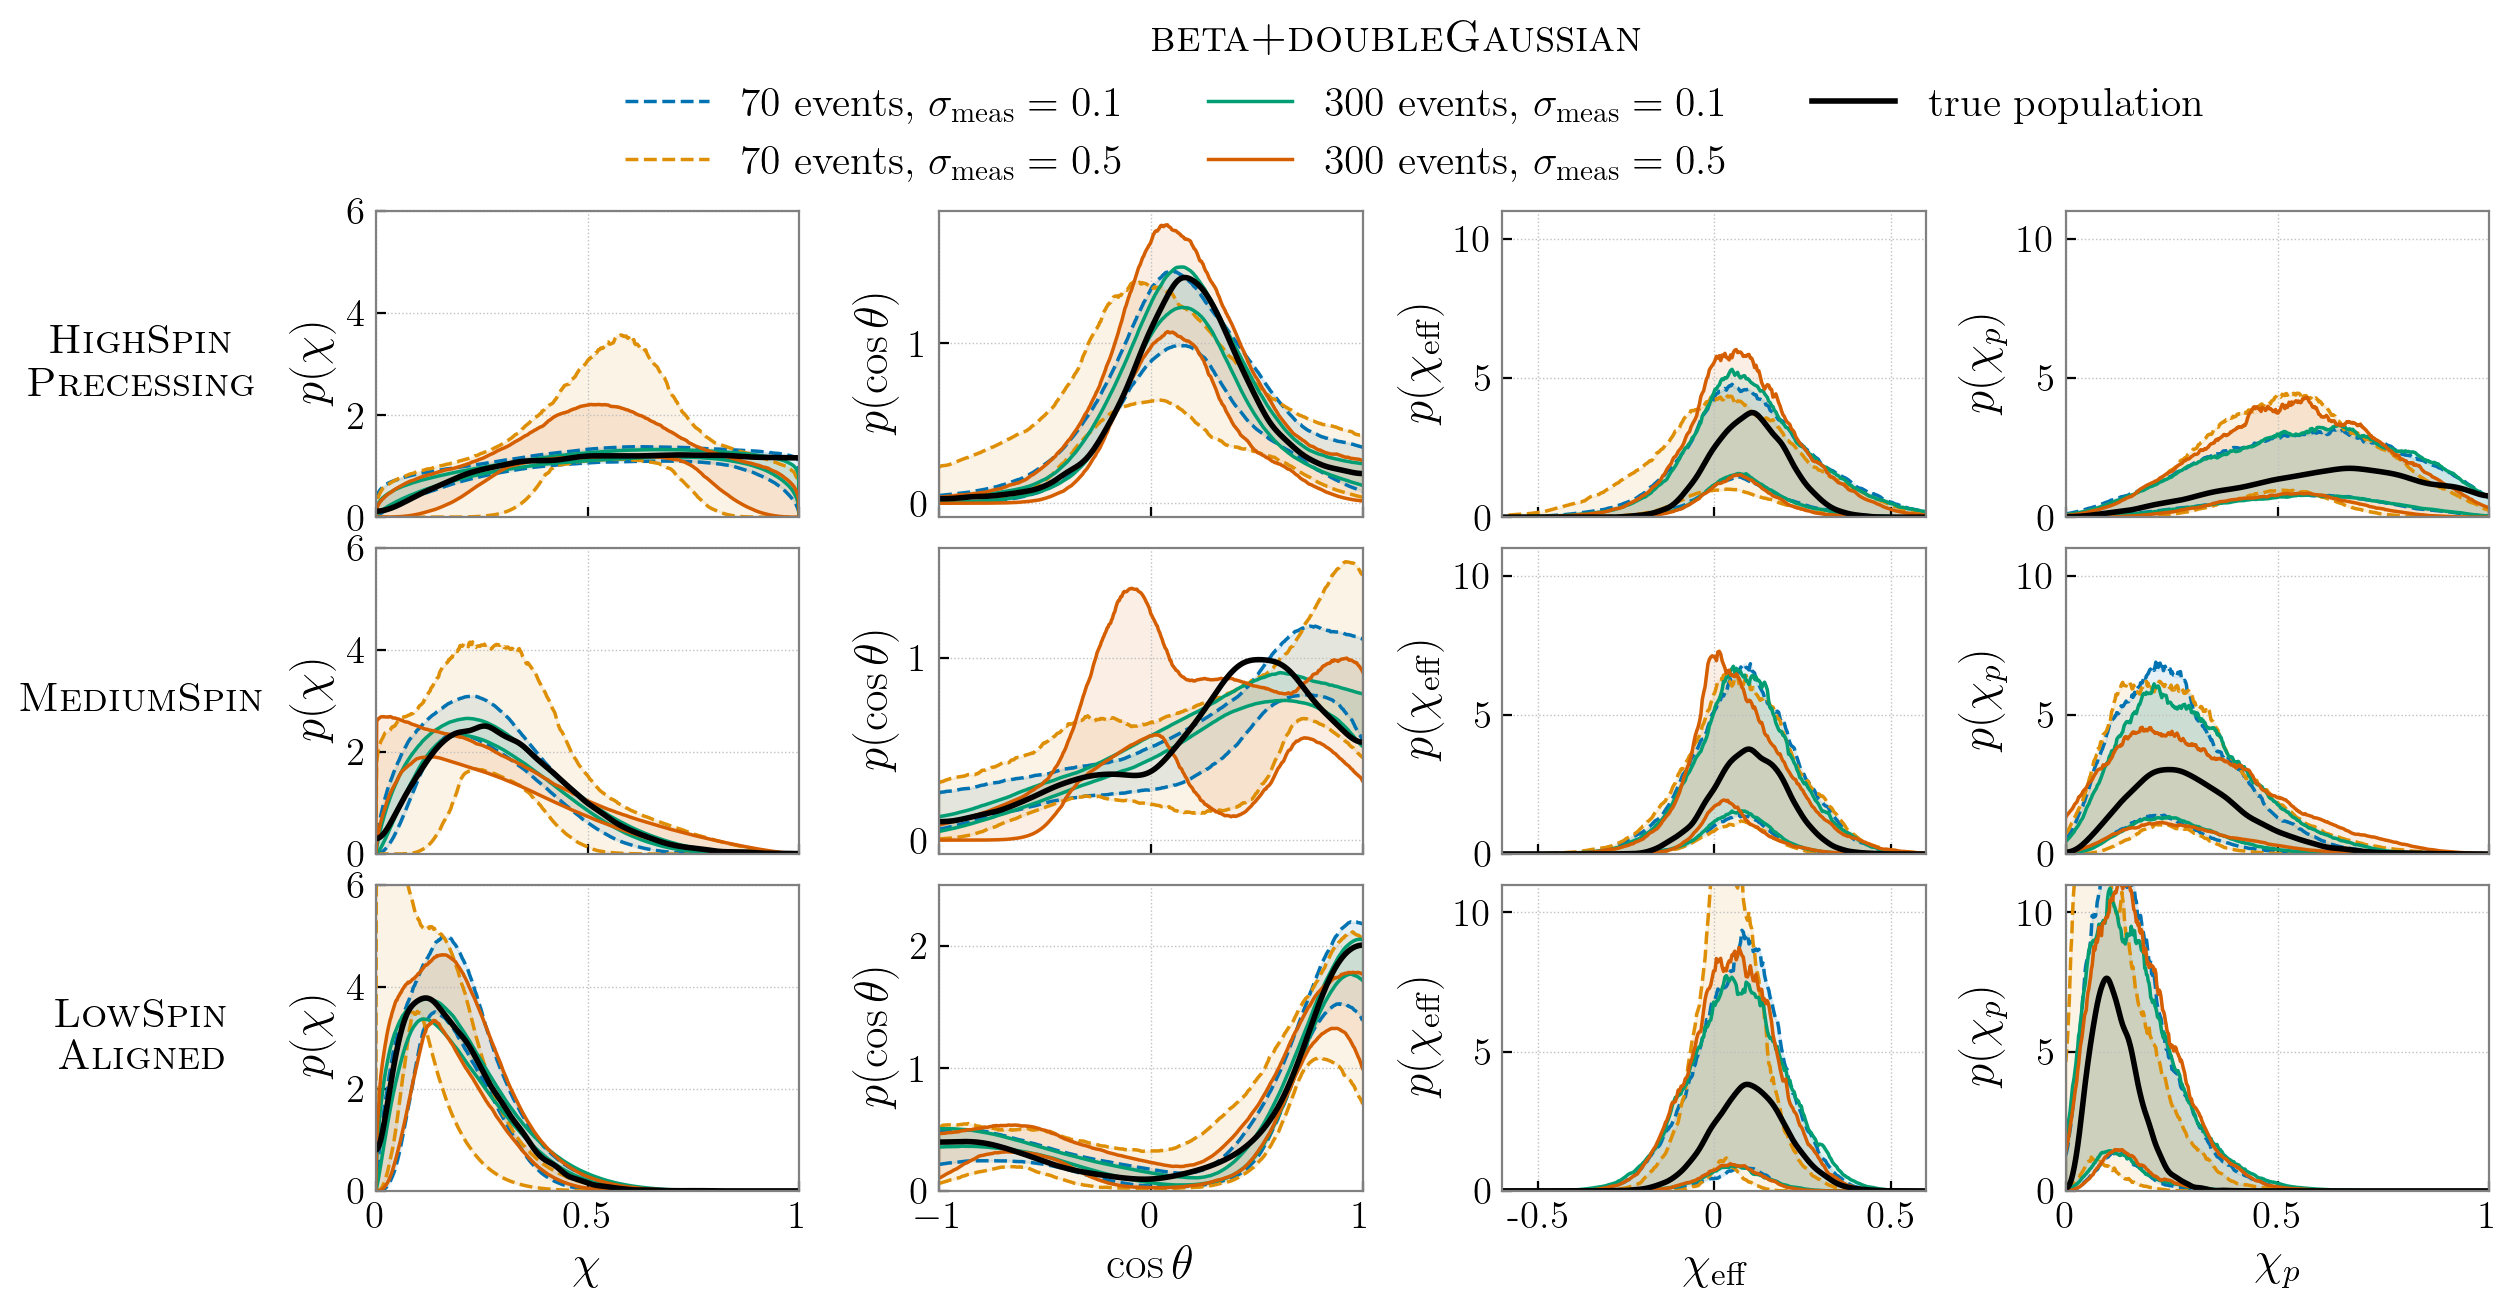

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15/1.1, 7/1.1))

for ax in axes: 
    for a in ax: 
        a.set_rasterization_zorder(2)

for i,pop_key in enumerate(kde_dict):
    for nevent in nevents: 
        nevent_key = nevent+' events'
        for sigma_meas in sigmas:
            
            k = nevent_key + ' '+ sigma_meas
            c = colors_dict[k]
            
            alph = 0.1
            lw = 1.25
            
            if nevent=='70': 
                ls='--'
            else: 
                ls = '-'
        
            ## Plot 5% and 95% credible bounds

            # spin magnitude
            p_chi = traces_dict[pop_key][nevent_key][f'gaussian_sigma_{sigma_meas}']['p_chi']
            chi_quants = np.quantile(p_chi, (0.05, 0.95), axis=0)
            axes[i][0].plot(chi_grid, chi_quants[0], color=c, ls=ls, lw=lw, label=labels_dict_2[k])
            axes[i][0].plot(chi_grid, chi_quants[1], color=c, ls=ls, lw=lw)
            axes[i][0].fill_between(chi_grid, chi_quants[0], y2=chi_quants[1], color=c, alpha=alph)
            
            # tilt angle
            p_cost = traces_dict[pop_key][nevent_key][f'gaussian_sigma_{sigma_meas}']['p_cost']
            cost_quants = np.quantile(p_cost, (0.05, 0.95), axis=0)
            axes[i][1].plot(cost_grid, cost_quants.T, color=c, ls=ls, lw=lw)
            axes[i][1].fill_between(cost_grid, cost_quants[0], y2=cost_quants[1], color=c, alpha=alph)

            # chi effective
            p_chieff = traces_dict[pop_key][nevent_key][f'gaussian_sigma_{sigma_meas}']['p_chieff']
            chieff_quants = np.quantile(p_chieff, (0.05, 0.95), axis=0)
            axes[i][2].plot(chieff_grid, chieff_quants.T, color=c, ls=ls, lw=lw)
            axes[i][2].fill_between(chieff_grid, chieff_quants[0], y2=chieff_quants[1], color=c, alpha=alph)

            # chi p
            p_chip = traces_dict[pop_key][nevent_key][f'gaussian_sigma_{sigma_meas}']['p_chip']
            chip_quants = np.quantile(p_chip, (0.05, 0.95), axis=0)
            axes[i][3].plot(chip_grid, chip_quants.T, color=c, ls=ls, lw=lw)
            axes[i][3].fill_between(chip_grid, chip_quants[0], y2=chip_quants[1], color=c, alpha=alph)
               
    ## Plot injected dists 
    
    # spin magnitude
    axes[i][0].plot(chi_grid, kde_dict[pop_key]['chi'], color='k', lw=2, label='true population')
    axes[i][0].set_xlim(0,1)
    axes[i][0].set_ylim(0,)
    
    # tilt angle
    axes[i][1].plot(cost_grid, kde_dict[pop_key]['cost'], color='k', lw=2)
    axes[i][1].set_xlim(-1,1)
    
    # chi effective
    axes[i][2].plot(chieff_grid, kde_dict[pop_key]['chieff'], color='k', lw=2)
    axes[i][2].set_xlim(-0.6,0.6)
    axes[i][2].set_ylim(0,11)
    
    # chi p
    axes[i][3].plot(chip_grid, kde_dict[pop_key]['chip'], color='k', lw=2)
    axes[i][3].set_xlim(0,1)
    axes[i][3].set_ylim(0,11)
    
    # y-axis labels
    axes[i][0].set_ylabel(r'$p(\chi)$', **label_kws)
    axes[i][1].set_ylabel(r'$p(\cos\theta)$', **label_kws)
    axes[i][2].set_ylabel(r'$p(\chi_\mathrm{eff})$', **label_kws)
    axes[i][3].set_ylabel(r'$p(\chi_p)$', **label_kws)  
    
    # set pop label
    axes[i][0].text(-0.55, 3, labels_dict[pop_key], fontsize=15, 
                    horizontalalignment='center', verticalalignment='center',)
    
    axes[i][0].set_ylim(0,6)
    
    if i!=2: 
        for ax in axes[i]: 
            ax.set_xticklabels([])

# x-axis labels
axes[2][0].set_xlabel(r'$\chi$', **label_kws)
axes[2][1].set_xlabel(r'$\cos\theta$', **label_kws)
axes[2][2].set_xlabel(r'$\chi_\mathrm{eff}$', **label_kws)
axes[2][3].set_xlabel(r'$\chi_p$', **label_kws)  

# Specific y limits for some 
axes[2][1].set_ylim(0,2.5)

# Add legend
axes[0][0].legend(bbox_to_anchor=(0.55, 1.04, 1., .102), loc='lower left',ncol=3, borderaxespad=0., fontsize=15)
for ax in axes: 
    for a in ax:
        a.grid(ls=':', color='silver', lw=0.5)
        
plt.subplots_adjust(hspace=0.1, wspace=0.33)

plt.suptitle(r'$\mathrm{\textsc{beta+doubleGaussian}}$', fontsize=16, y=1.03)

for ax in axes:
    for a in ax:
        a.spines['bottom'].set_color('gray')
        a.spines['top'].set_color('gray') 
        a.spines['right'].set_color('gray')
        a.spines['left'].set_color('gray')
        
        
axes[2][0].set_xticklabels([int(0), 0.5, int(1)])
axes[2][2].set_xticks([-0.5, int(0), 0.5])
axes[2][2].set_xticklabels([-0.5, int(0), 0.5])
axes[2][3].set_xticklabels([int(0), 0.5, int(1)])
    
plt.savefig('figure_05.pdf',bbox_inches='tight')
plt.show()